In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,LSTM
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K

from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout

import cv2
import shutil
import glob
import os

In [2]:
base_path='../input/braintumor/Brain/train'
filepaths=[]
labels=[]
for (dir_path, dir_names, file_names) in os.walk(base_path):
    for i in file_names:
        filepaths.append(dir_path+'/'+i)
        if 'Tr-no' in (i.split('_')):
            labels.append("No")
        else: 
            labels.append("Yes")
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  5712    labels:  5712


In [3]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(5712,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,../input/braintumor/Brain/train/pituitary/Tr-p...,Yes
1,../input/braintumor/Brain/train/pituitary/Tr-p...,Yes
2,../input/braintumor/Brain/train/pituitary/Tr-p...,Yes
3,../input/braintumor/Brain/train/pituitary/Tr-p...,Yes
4,../input/braintumor/Brain/train/pituitary/Tr-p...,Yes


In [4]:
print(df['labels'].value_counts())

Yes    4128
No     1584
Name: labels, dtype: int64


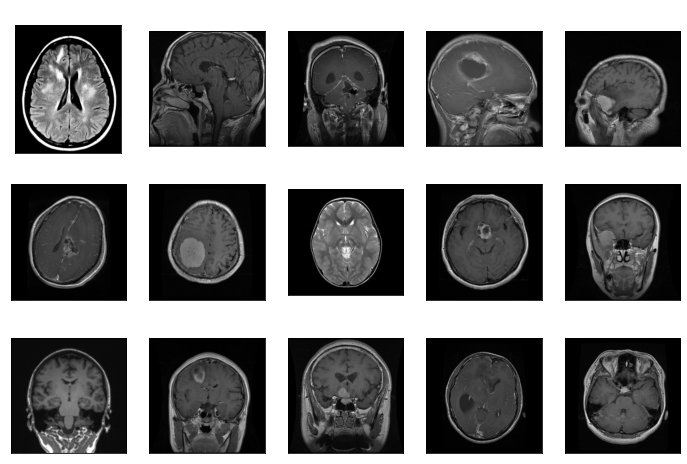

In [5]:
plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.80, random_state=0)
train_new, valid = train_test_split(train, train_size=0.85, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (3883, 2)
test set shape: (1143, 2)
validation set shape: (686, 2)


In [7]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [8]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (150,150), batch_size = 16, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(150,150), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (150,150), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 3883 validated image filenames belonging to 2 classes.
Found 686 validated image filenames belonging to 2 classes.
Found 1143 validated image filenames belonging to 2 classes.


In [9]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

In [10]:
# base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', input_shape = (150,150,3),
#                                                      include_top=False)
    
# model = Sequential()
# model.add(base_model)
# model.add(GlobalAveragePooling2D())
# model.add(Dense(128, activation = 'relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Reshape())


# model.add(Dense(1, activation = 'sigmoid'))
# model.summary()

**MODEL CNN + LSTM**

In [12]:
import os
input_data = Input(shape=(200,200,3), name='input')

base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', input_shape = (200,200,3),
                                                     include_top=False)
    


inner=base_model(input_data)

inner = MaxPooling2D(pool_size=(2, 2), name='pool')(inner)
inner=Dense(128,activation='relu',name='dense')(inner)
inner=BatchNormalization()(inner)
inner=Dropout(0.2)(inner)



inner = Reshape(target_shape=((inner.shape[1]*inner.shape[2],-1)), name='reshape')(inner)


inner = LSTM(100,return_sequences=True,name='lstm')(inner)

inner=Flatten()(inner)
inner = Dense(1,name='dense2')(inner)
y_pred = Activation('sigmoid', name='sigmoid')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 200, 200, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
pool (MaxPooling2D)          (None, 2, 2, 1536)        0         
_________________________________________________________________
dense (Dense)                (None, 2, 2, 128)         196736    
_________________________________________________________________
batch_normalization_407 (Bat (None, 2, 2, 128)         512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 128)         0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 128)            0     

**Model Tarining**

In [13]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', verbose=1),
]


model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.0001), metrics=['accuracy',tf.keras.metrics.AUC(
    num_thresholds=200,
    curve="ROC",
    summation_method="interpolation",
    name=None,
    dtype=None,
    thresholds=None,
    multi_label=False,
    label_weights=None,
),tf.keras.metrics.Precision( thresholds=None, top_k=None, class_id=None, name=None, dtype=None ),tf.keras.metrics.Recall( thresholds=None, top_k=None, class_id=None, name=None, dtype=None ),tf.keras.metrics.TruePositives(thresholds=None, name=None, dtype=None),tf.keras.metrics.TrueNegatives(thresholds=None, name=None, dtype=None),tf.keras.metrics.FalsePositives(thresholds=None, name=None, dtype=None),tf.keras.metrics.FalseNegatives(thresholds=None, name=None, dtype=None)])


history = model.fit(train_gen, validation_data = val_gen, epochs = 40, callbacks = [callbacks], verbose = 1)

2022-09-08 16:38:01.368344: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-09-08 16:38:20.345717: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


243/243 [==============================] - 99s 302ms/step - loss: 0.3038 - accuracy: 0.9186 - auc: 0.9582 - precision: 0.9593 - recall: 0.9273 - true_positives: 2614.0000 - true_negatives: 953.0000 - false_positives: 111.0000 - false_negatives: 205.0000 - val_loss: 0.1993 - val_accuracy: 0.9198 - val_auc: 0.9888 - val_precision: 0.9033 - val_recall: 0.9960 - val_true_positives: 495.0000 - val_true_negatives: 136.0000 - val_false_positives: 53.0000 - val_false_negatives: 2.0000
Epoch 2/40
243/243 [==============================] - 52s 215ms/step - loss: 0.1175 - accuracy: 0.9642 - auc: 0.9884 - precision: 0.9796 - recall: 0.9709 - true_positives: 2737.0000 - true_negatives: 1007.0000 - false_positives: 57.0000 - false_negatives: 82.0000 - val_loss: 0.0753 - val_accuracy: 0.9752 - val_auc: 0.9963 - val_precision: 0.9800 - val_recall: 0.9859 - val_true_positives: 490.0000 - val_true_negatives: 179.0000 - val_false_positives: 10.0000 - val_false_negatives: 7.0000
Epoch 3/40
243/243 [======

***Model Test***

In [14]:
model.load_weights("Tumor_classifier_model.h5")
model.evaluate(test_gen)

72/72 [==============================] - 10s 140ms/step - loss: 0.0416 - accuracy: 0.9913 - auc: 0.9971 - precision: 0.9975 - recall: 0.9901 - true_positives: 804.0000 - true_negatives: 329.0000 - false_positives: 2.0000 - false_negatives: 8.0000


[0.041555970907211304,
 0.9912511110305786,
 0.9970793128013611,
 0.9975185990333557,
 0.9901477694511414,
 804.0,
 329.0,
 2.0,
 8.0]

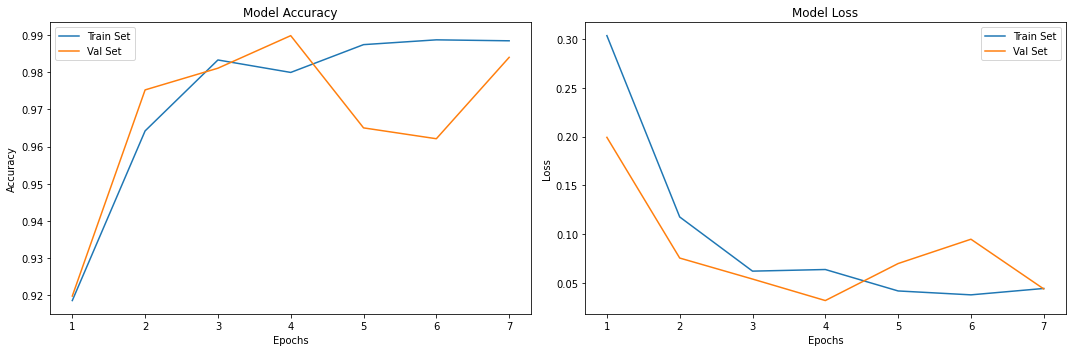

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()